# Breaching privacy

This notebook does the same job as the cmd-line tool `breach.py`, but also directly visualizes the user data and reconstruction

In [179]:
import torch
import hydra
from omegaconf import OmegaConf
%load_ext autoreload
%autoreload 2

import breaching

import copy
import matplotlib.pyplot as plt 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Initialize cfg object and system setup:

This will print out all configuration options. 
There are a lot of possible configurations, but there is usually no need to worry about most of these. Below, a few options are printed.

In [2]:
with hydra.initialize(config_path="config"):
    cfg = hydra.compose(config_name='cfg', overrides=['attack=invertinggradients',
                                                      'case=1_single_image_small'])
    print(f'Investigating use case {cfg.case.name} with server type {cfg.case.server.name}.')
    print('Attack settings are:')
    print(OmegaConf.to_yaml(cfg.attack))
          
device = torch.device(f'cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case single_image_small with server type honest_but_curious.
Attack settings are:
type: invertinggradients
attack_type: optimization
objective:
  type: cosine-similarity
  scale: 1.0
restarts:
  num_trials: 1
  scoring: cosine-similarity
init: randn
optim:
  optimizer: adam
  signed: true
  step_size: 0.1
  boxed: true
  max_iterations: 24000
  step_size_decay: step-lr
  langevin_noise: 0.0
  warmup: 0
  callback: 1000
regularization:
  total_variation:
    scale: 0.2
    inner_exp: 1
    outer_exp: 1
  orthogonality:
    scale: 0.0



{'device': device(type='cuda'), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations:

In [292]:
cfg.case.user.data_idx = 0
cfg.case.model='ConvNetSmall'

cfg.case.user.num_data_points=10


cfg.case.server.model_state = 'trained'

# The total variation scale should be small for CIFAR images
cfg.attack.regularization.total_variation.scale = 1e-4

cfg.attack.objective.type = 'cosine-similarity'
cfg.attack.objective.scale = 1
cfg.attack.optim.signed=False

### Instantiate all parties

In [396]:
user, server = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)

Files already downloaded and verified
Model architecture <class 'breaching.cases.models.model_preparation.ConvNetSmall'> loaded with 983,946 parameters and 0 buffers.
Overall this is a data ratio of      32:1 for target shape [10, 3, 32, 32] given that num_queries=1.


In [397]:
print(user)
print(server)
print(attacker)

server.model.to(**setup)

User (of type UserSingleStep with settings:
            number of local updates: 1
            number of data points: 10
            number of user queries 1

            Threat model:
            User provides labels: True
            User provides number of data points: True

            Model:
            model specification: ConvNetSmall
            loss function: CrossEntropyLoss()

            Data:
            Dataset: CIFAR10
            data_idx: 0
        


ConvNetSmall(
  (model): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): ReLU()
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
    (pool0): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU()
    (pool1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Linear(in_features=2304, out_features=10, bias=True)
  )
)

## Malicious server: Modify the model parameters here

In [426]:
bias_set = False
with torch.no_grad():
    for module in server.model.modules():
        # if isinstance(module, torch.nn.BatchNorm2d):
            # module.weight.data = module.running_var.data.clone()
            # module.bias.data = module.running_mean.data.clone() + 10
        if isinstance(module, torch.nn.Conv2d):
# Grouping stuff:
#             num_groups = module.out_channels // module.in_channels
#             surviving_features = module.weight[:module.in_channels, 0:1]
#             torch.nn.init.orthogonal_(surviving_features)
#             module.weight.data = torch.zeros_like(module.weight)
                
#             idx = 0
#             for group in range(num_groups):
#                 module.weight.data[idx:idx+module.in_channels, group:group+1] = surviving_features
#                 idx += module.in_channels

# Other replication stuff:            
            initial_filters = module.weight[0:1]
            torch.nn.init.orthogonal_(initial_filters)
            #torch.nn.init.dirac_(initial_filters)
            # torch.nn.init.constant_(initial_filters, 1.0)
            #print(initial_filters.data)
            initial_filters = torch.eye(3, **setup).repeat(1, module.in_channels, 1, 1)
            module.weight.data = torch.cat([initial_filters] * module.out_channels).contiguous()
            module.bias.data = torch.zeros_like(module.bias.data)
            
        if isinstance(module, torch.nn.Linear):
            # module.bias.data = torch.zeros_like(module.bias.data)
            # module.weight.data = torch.cat([module.weight.data[0:1]] * module.weight.shape[0], dim=0).contiguous()
            torch.nn.init.orthogonal_(module.weight.data)
            
#     for module in user.model.modules():
#         if isinstance(module, torch.nn.Conv2d):
#             module.groups = module.in_channels        
#     for module in attacker.model_template.modules():
#         if isinstance(module, torch.nn.Conv2d):
#             module.groups = module.in_channels   

### Mess up activations?

In [428]:
class ModdedHardTanh(torch.nn.Module):
    def __init__(self, min_val=-1, max_val=1):
        super().__init__()
        self.hardtanh = torch.nn.Hardtanh(min_val, max_val)
        self.min_val = self.hardtanh.min_val
        self.max_val = self.hardtanh.max_val
    def forward(self, inputs):
        return (self.hardtanh(inputs) + 1) / 2

In [429]:
def convert_relu_to(model, activation=torch.nn.Sigmoid, args=[]):
    for child_name, child in model.named_children():
        if isinstance(child, torch.nn.ReLU):
            setattr(model, child_name, activation(*args))
        else:
            convert_relu_to(child, activation, args)
            

new_activation = ModdedHardTanh
args = [0, 1]

convert_relu_to(server.model, activation=new_activation, args=args)
convert_relu_to(user.model, activation=new_activation, args=args)
convert_relu_to(attacker.model_template, activation=new_activation, args=args)

In [430]:
server.model

ConvNetSmall(
  (model): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): ModdedHardTanh(
      (hardtanh): Hardtanh(min_val=0, max_val=0.060505032539367676)
    )
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ModdedHardTanh(
      (hardtanh): Hardtanh(min_val=0, max_val=0.026179790496826172)
    )
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ModdedHardTanh(
      (hardtanh): Hardtanh(min_val=0, max_val=0.01615118980407715)
    )
    (pool0): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ModdedHardTanh(
      (hardtanh): Hardtanh(min_val=0, max_val=0.012541651725769043)
    )
    (pool1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (lin

### Space biases

In [431]:
features = dict()
in_features = dict()
def named_hook(name):
    def hook_fn(module, input, output):
        features[name] = output
        in_features[name] = input[0]
    return hook_fn

In [432]:
with torch.no_grad():
    for name, module in server.model.named_modules():
        if isinstance(module, (torch.nn.Conv2d)):
            hook = module.register_forward_hook(named_hook(name))


            # random_data_sample = torch.randn(1024, 3, 32, 32, **setup)
            random_data_sample = true_user_data['data'] #ground truth data sample for testing

            module.bias.data = torch.zeros_like(module.bias)

            server.model(random_data_sample)
            std, mu = torch.std_mean(features[name])
            print(f'mean of layer {name} is {mu.item()}, std is {std.item()}')
            with torch.no_grad():
                module.weight.data = module.weight.data / (std  + 1e-6)
                module.bias.data = torch.linspace(-1.96 - mu, 1.96 + mu, module.bias.numel()).to(**setup)
                bin_val = module.bias.data[1] - module.bias.data[0]
                print(bin_val)
            
            server.model(random_data_sample)
            std, mu = torch.std_mean(features[name])
            print(f'mean of layer {name} is {mu.item()}, std is {std.item()}')  
            
            hook.remove()
            
        if isinstance(module, (torch.nn.Hardtanh, ModdedHardTanh)):
            module.min_val = 0
            module.max_val = bin_val

mean of layer model.conv0 is 0.8996915817260742, std is 6.904912948608398
tensor(0.0908, device='cuda:0')
mean of layer model.conv0 is 0.13029727339744568, std is 1.952559232711792
mean of layer model.conv1 is 96.36192321777344, std is 11.267404556274414
tensor(1.5484, device='cuda:0')
mean of layer model.conv1 is 8.552268028259277, std is 57.22018051147461
mean of layer model.conv2 is 338.02728271484375, std is 39.77992630004883
tensor(2.6666, device='cuda:0')
mean of layer model.conv2 is 8.497422218322754, std is 197.0625762939453
mean of layer model.conv3 is 792.3672485351562, std is 158.7686004638672
tensor(6.2300, device='cuda:0')
mean of layer model.conv3 is 4.990692138671875, std is 460.4020080566406


In [433]:
print(features['model.conv1'][0,:,0,0] - server.model.model[2].bias)
print(features['model.conv1'][:,0,0,0] - server.model.model[2].bias[0])

tensor([5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087,
        5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087,
        5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087,
        5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087,
        5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087,
        5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087,
        5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087,
        5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087,
        5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087,
        5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087,
        5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087,
        5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087, 5.9087,
        5.9087, 5.9087, 5.9087, 5.9087, 

In [434]:
def plot_map(feature_map):
    min_val, max_val = feature_map.amin(dim=[2,3], keepdim=True), feature_map.amax(dim=[2,3], keepdim=True)
    renorm_map = (feature_map - min_val) / (max_val - min_val)
    print(renorm_map[0, :3].permute(1, 2, 0).detach().cpu().shape)
    plt.imshow(renorm_map[0, :3].permute(1, 2, 0).detach().cpu())
    plt.show()

In [435]:
def plot_grid_features(data):
    grid_shape = int(torch.as_tensor(data.shape[0]).sqrt().ceil())
    s = 10
    fig, axes = plt.subplots(grid_shape, grid_shape, figsize=(s, s))
    label_classes = []
    min_val, max_val = data.amin(dim=[1,2], keepdim=True), data.amax(dim=[1,2], keepdim=True)
    # data = (data - min_val) / (data - min_val)
    for i, (im, axis) in enumerate(zip(data, axes.flatten())):
        axis.imshow(im.cpu())
        axis.axis('off')

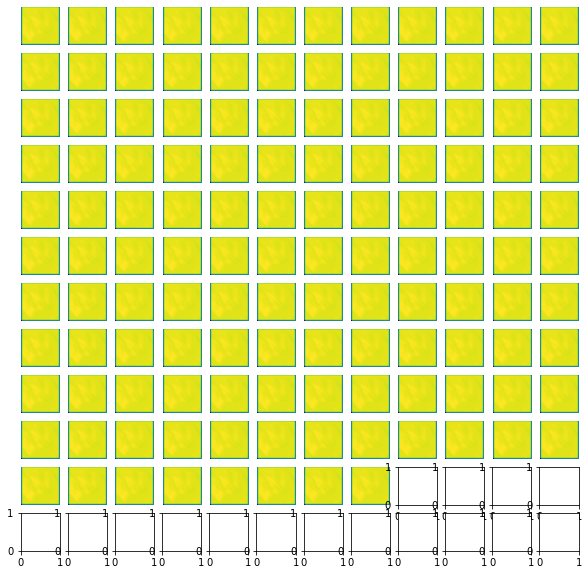

In [436]:
plot_grid_features(features['model.conv1'][0])

torch.Size([32, 32, 3])


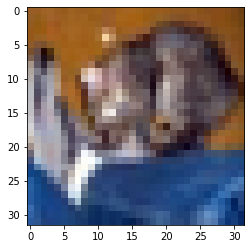

torch.Size([32, 32, 1])


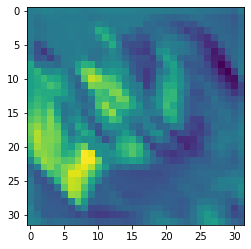

torch.Size([32, 32, 1])


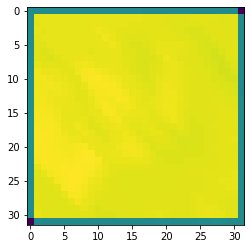

torch.Size([10, 10, 1])


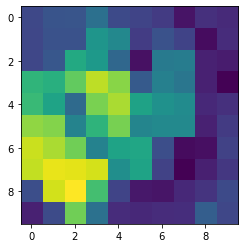

In [437]:
plot_map(in_features['model.conv0'])
plot_map(in_features['model.conv1'].sum(dim=1, keepdim=True))
plot_map(in_features['model.conv2'].sum(dim=1, keepdim=True))
plot_map(in_features['model.conv3'].sum(dim=1, keepdim=True))

In [409]:
attacker.model_template = copy.deepcopy(server.model)
user.model = copy.deepcopy(server.model)
user.model

ConvNetSmall(
  (model): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): ModdedHardTanh(
      (hardtanh): Hardtanh(min_val=0, max_val=0.06222224235534668)
    )
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ModdedHardTanh(
      (hardtanh): Hardtanh(min_val=0, max_val=0.030866146087646484)
    )
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ModdedHardTanh(
      (hardtanh): Hardtanh(min_val=0, max_val=0.015372514724731445)
    )
    (pool0): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ModdedHardTanh(
      (hardtanh): Hardtanh(min_val=0, max_val=0.015372514724731445)
    )
    (pool1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (lin

### Simulate an attacked FL protocol

True user data is returned only for analysis

In [410]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)  

In [411]:
[(g.mean(), g.std()) for g in shared_data['gradients'][0]]

[(tensor(-9.0750e-10, device='cuda:0'), tensor(5.1006e-08, device='cuda:0')),
 (tensor(3.7244e-10, device='cuda:0'), tensor(5.2837e-08, device='cuda:0')),
 (tensor(6.5134e-09, device='cuda:0'), tensor(1.3165e-07, device='cuda:0')),
 (tensor(1.3215e-08, device='cuda:0'), tensor(2.5962e-07, device='cuda:0')),
 (tensor(-5.8975e-08, device='cuda:0'), tensor(2.1458e-06, device='cuda:0')),
 (tensor(-2.5665e-07, device='cuda:0'), tensor(4.8445e-06, device='cuda:0')),
 (tensor(7.2260e-07, device='cuda:0'), tensor(1.1544e-05, device='cuda:0')),
 (tensor(1.4283e-06, device='cuda:0'), tensor(2.2853e-05, device='cuda:0')),
 (tensor(-4.2233e-09, device='cuda:0'), tensor(0.0366, device='cuda:0')),
 (tensor(-1.1176e-08, device='cuda:0'), tensor(0.0767, device='cuda:0'))]

['cat', 'airplane', 'horse', 'frog', 'deer', 'truck', 'horse', 'bird', 'ship', 'airplane']


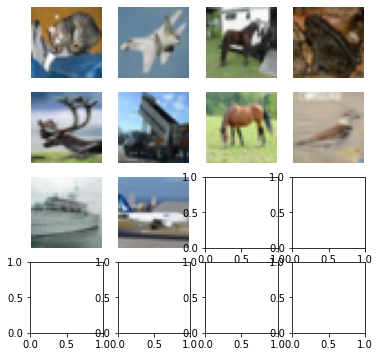

In [346]:
user.plot(true_user_data)

### Reconstruct user data:

In [347]:
reconstructed_user_data, stats = attacker.reconstruct(server_payload, shared_data, 
                                                      server.secrets, dryrun=cfg.dryrun)

It: 1. Rec. loss: 0.0002. T: 0.01s
It: 1001. Rec. loss: 0.0000. T: 14.11s
It: 2001. Rec. loss: 0.0000. T: 14.17s
It: 3001. Rec. loss: 0.0000. T: 14.18s
It: 4001. Rec. loss: 0.0000. T: 14.18s
It: 5001. Rec. loss: 0.0000. T: 14.16s
It: 6001. Rec. loss: 0.0000. T: 14.18s
Recovery interrupted manually in iteration 6991!
Optimal condidate solution with rec. loss 0.0000 selected.


In [348]:
# How good is the reconstruction?
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, 
                                    server_payload, server.model, setup, order_batch=False)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/jonas/miniconda3/envs/dl/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth
METRICS: | MSE: 0.0744 | PSNR: 11.66 | FMSE: 0.0000e+00 | LPIPS: 0.27| R-PSNR: 11.66


['cat', 'airplane', 'horse', 'frog', 'deer', 'truck', 'horse', 'bird', 'ship', 'airplane']


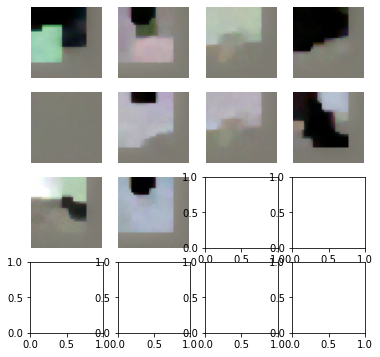

In [349]:
user.plot(reconstructed_user_data)

In [351]:
# How good is the reconstruction?
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, 
                                    server_payload, server.model, setup, order_batch=True)
ordered_user_data = dict(data=reconstructed_user_data['data'][metrics['order']],
                         labels=reconstructed_user_data['labels'])

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/jonas/miniconda3/envs/dl/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth
METRICS: | MSE: 0.0774 | PSNR: 11.78 | FMSE: 1.9963e-16 | LPIPS: 0.23| R-PSNR: 11.78


['cat', 'airplane', 'horse', 'frog', 'deer', 'truck', 'horse', 'bird', 'ship', 'airplane']


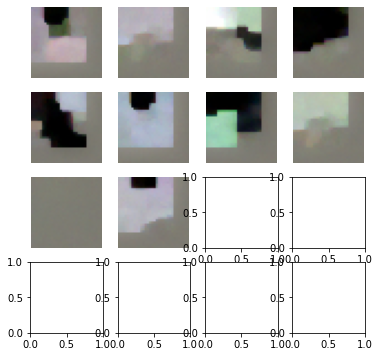

In [352]:
user.plot(ordered_user_data)

PSNR without parameter modifications and 10 data points: 16-17